In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

import colour as col
import colour.notation as cn
import colour.plotting as cp
import colour.models as cm

import skimage.measure as sm

from matplotlib.colors import to_hex

In [2]:
rc_params = {prop:'#777777' for prop in ['axes.edgecolor', 'xtick.color', 'ytick.color', 'axes.labelcolor', 'lines.color']}
rc_params['figure.facecolor'] = '#111111'
rc_params['axes.facecolor'] = '#111111'

def signed_func_rgb_gamut(L,C,H):
    """ A signed function that becomes zero when the cylindrical OKLab coordinates L,C,H falls on the sRGB gamut. 
    This is not a true signed-distance-function, but it is good enough for root-finding the gamut boundaries.

    Parameters:
        L: OKLab lighness
        C: OKLab chroma
        H: OKLab hue
    """
    lab_col = (L,C*np.cos(H),C*np.sin(H))
    rgb_col = cm.XYZ_to_sRGB(cm.Oklab_to_XYZ(lab_col))
    return np.linalg.norm(2*rgb_col-1, np.inf)-1    
    
def get_max_chroma(L,H):
    """ Returns the maximal OKLab chroma inside the sRGB gamut for a given OKLab lightness and hue.

    Parameters:
        L: OKLab lighness
        H: OKLab hue
    """
    return opt.brenth(lambda C : signed_func_rgb_gamut(L,C,H), 0, 1)
    
def plot_gamut_in_oklab(L, fignum=None, Ns=64, figure=None, axes=None):
    """ Wrapper to colour.plotting.plot_RGB_colourspace_section allowing to plot a section of the sRGB gamut in OKLab with a
    dark background.

    Parameters:
        L: OKLab lighness
        fignum [optional]: a number or string for referencing the graph
        Ns [optional, default=64]: number of segments used to discretize the sRGB gamut cube.

    Returns:
        plt.Figure, plt.Axis
    """    
    with plt.rc_context(rc_params):
        if figure is not None and axes is not None:
            fig,ax = figure,axes
        else:
            plt.close(fignum)
            fig,ax = plt.subplots(num=fignum)
        cp.plot_RGB_colourspace_section("sRGB", model="Oklab", origin=L, segments=Ns, section_colours="RGB", show_section_contour=False,
                                        figure=fig, axes=ax, tight_layout=True, title="", bounding_box=(-0.26,0.30,-0.34,0.22),
                                        show=figure is None or axes is None)
        return fig,ax
        
def plot_compact_colour_swatch(cols, fignum=None):
    """ A wrapper to colour.plotting.plot_single_colour_swatch with a compact figure size for jupyter notebooks.

    Parameters:
        cols: ndarray of shape (...,3) containing a set of sRGB colour
        fignum [optional]: a number or string for referencing the graph

    Returns:
        plt.Figure, plt.Axis
    """
    fig,ax = plt.subplots(figsize=(10,1.5), num=fignum)
    ax.set_axis_off()
    cp.plot_single_colour_swatch(cols, figure=fig, axes=ax)
    return fig,ax
    
def plot_single_circular_swatch(cols, fignum=None, Ns=101, figure=None, axes=None):
    """ Plot a set of colors in a ring-like fashion. 

    Parameters:
        cols: ndarray of shape (...,3) containing a set of sRGB colour
        fignum [optional]: a number or string for referencing the graph
        Ns [optional, default=101]: number of points used to discretize each of the ring segments.

    Returns:
        plt.Figure, plt.Axis
    """
    r1, r2 = 0.5,2
    
    if figure is not None and axes is not None:
        fig,ax = figure,axes
    else:
        if fignum is not None:
            plt.close(fignum)
        fig,ax = plt.subplots(num=fignum)
        fig.tight_layout()
        fig.patch.set_facecolor('#111111')
    ax.axis('equal')
    ax.axis('off')
    ax.axis([-r2,r2,-r2,r2])
    
    Nc = cols.shape[0]
    theta_vals = np.linspace(0, 2*np.pi, Ns*Nc) + 3*np.pi/8
    for ic,col in enumerate(cols):
        theta_segm = theta_vals[ic*Ns:(ic+1)*Ns+1]
        x = np.concatenate((r1*np.cos(theta_segm), r2*np.cos(np.flip(theta_segm))))
        y = np.concatenate((r1*np.sin(theta_segm), r2*np.sin(np.flip(theta_segm))))
        ax.fill(x, y, to_hex(np.minimum(1,np.maximum(0,col))))
    return fig,ax

def plot_multi_circular_swatch(*palettes, fignum=None, Ns=101):
    """ Plot a set of colors in a ring-like fashion. 

    Parameters:
       *palettes: several ndarray of shape (...,3) containing sets of sRGB colour
        fignum [optional]: a number or string for referencing the graph
        Ns [optional, default=101]: number of points used to discretize each of the ring segments.

    Returns:
        plt.Figure, plt.Axis
    """
    Np = len(palettes)
    if fignum is not None:
        plt.close(fignum)
    fig,axes = plt.subplots(figsize=(10,10/Np), ncols=Np, num=fignum)
    fig.tight_layout()
    fig.patch.set_facecolor('#111111')
    for ip, cols in enumerate(palettes):
        plot_single_circular_swatch(cols, Ns=Ns, figure=fig, axes=axes[ip])
    return fig, axes

In [3]:
class Palette:
    def __init__(self):
        self.oklab = {}
        self.rgb = {}
        self.cam16 = {}
        self.hex = {}
        
    def add_group(self, group_name, *, oklab=None, rgb=None):        
        if oklab is not None:
            self.oklab[group_name] = oklab
            self.rgb[group_name] = cm.XYZ_to_sRGB(cm.Oklab_to_XYZ(oklab))
        elif rgb is not None:
            self.rgb[group_name] = rgb
            self.oklab[group_name] = cm.XYZ_to_Oklab(cm.sRGB_to_XYZ(rgb))
        self.cam16[group_name] = cm.XYZ_to_CAM16UCS(cm.sRGB_to_XYZ(self.rgb[group_name]))
        self.hex[group_name] = cn.RGB_to_HEX(self.rgb[group_name])

    def print_delta_E(self, group_name, circular=True):
        if group_name in self.cam16.keys():
            colours = self.cam16[group_name]
            if circular:
                print(col.delta_E(colours, np.roll(colours,-1,axis=0), method="CAM16-UCS"))
            else:
                print(col.delta_E(colours[1:], colours[:-1], method="CAM16-UCS"))

In [4]:
##############################
# Original solarized palette #
##############################

raw_palette = \
"""SOLARIZED HEX     16/8 TERMCOL  XTERM/HEX   L*A*B      RGB         HSB
base03    #002b36  8/4 brblack  234 #1c1c1c 15 -12 -12   0  43  54 193 100  21
base02    #073642  0/4 black    235 #262626 20 -12 -12   7  54  66 192  90  26
base01    #586e75 10/7 brgreen  240 #585858 45 -07 -07  88 110 117 194  25  46
base00    #657b83 11/7 bryellow 241 #626262 50 -07 -07 101 123 131 195  23  51
base0     #839496 12/6 brblue   244 #808080 60 -06 -03 131 148 150 186  13  59
base1     #93a1a1 14/4 brcyan   245 #8a8a8a 65 -05 -02 147 161 161 180   9  63
base2     #eee8d5  7/7 white    254 #e4e4e4 92 -00  10 238 232 213  44  11  93
base3     #fdf6e3 15/7 brwhite  230 #ffffd7 97  00  10 253 246 227  44  10  99
yellow    #b58900  3/3 yellow   136 #af8700 60  10  65 181 137   0  45 100  71
orange    #cb4b16  9/3 brred    166 #d75f00 50  50  55 203  75  22  18  89  80
red       #dc322f  1/1 red      160 #d70000 50  65  45 220  50  47   1  79  86
magenta   #d33682  5/5 magenta  125 #af005f 50  65 -05 211  54 130 331  74  83
violet    #6c71c4 13/5 brmagenta 61 #5f5faf 50  15 -45 108 113 196 237  45  77
blue      #268bd2  4/4 blue      33 #0087ff 55 -10 -45  38 139 210 205  82  82
cyan      #2aa198  6/6 cyan      37 #00afaf 60 -35 -05  42 161 152 175  74  63
green     #859900  2/2 green     64 #5f8700 60 -20  65 133 153   0  68 100  60"""
rgb_cols = cn.HEX_to_RGB([line.split()[1] for line in raw_palette.split("\n")[1:]])

solarized = Palette()
solarized.add_group("base", rgb=rgb_cols[:8])
solarized.add_group("accent", rgb=rgb_cols[8:])

[ 17.47115855  17.59648499  23.54330763  24.31090311  24.40488863
  32.28281225  25.75340315  19.03706689]


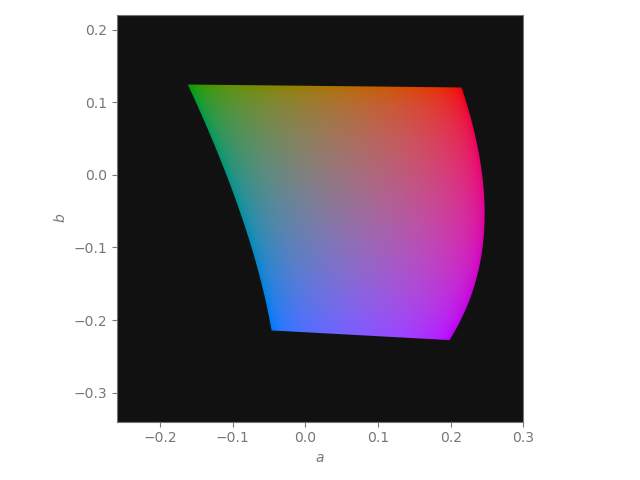

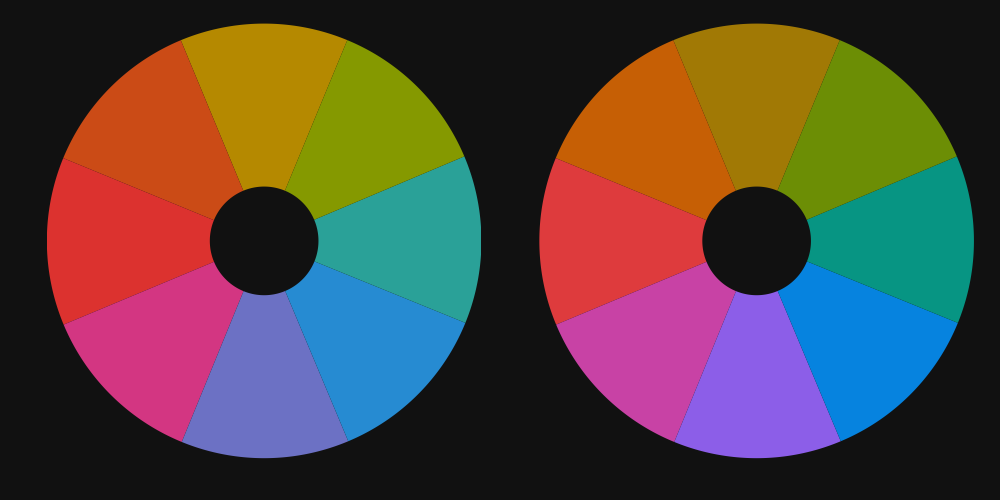

In [5]:
###############################
# New Solarized-OKLab palette #
###############################

# First, we define the default accent colours from lightness, hue and chroma values in OKLab
L = 0.6
hvals = np.array([85,51,25,340,295,250,180,125])*np.pi/180
cvals = np.minimum(np.ones_like(hvals)*0.2, 0.99*np.array(list([get_max_chroma(L,H) for H in hvals])))

solarized_oklab = Palette()
solarized_oklab.add_group("accent", oklab=np.stack((np.ones_like(cvals)*L, cvals*np.cos(hvals), cvals*np.sin(hvals)), axis=-1))
solarized_oklab.print_delta_E("accent")

fig,ax = plot_gamut_in_oklab(L, "sRGB Gamut in Oklab + Solarized-OKLab accent colours")
ax.plot(*solarized_oklab.oklab["accent"][:,1:].T, 'wo', mfc='none')

plot_multi_circular_swatch(solarized.rgb["accent"], solarized_oklab.rgb["accent"], fignum="Solarized and Solarized-OKLab accent colours");

In [6]:
# Check if the distance between accent colours are more uniform in the new colourscheme
solarized.print_delta_E("accent")
solarized_oklab.print_delta_E("accent")

[ 27.03596796   9.7613923   17.53405926  37.81298619  16.03365822
  25.28520833  30.56157772  16.09219725]
[ 17.47115855  17.59648499  23.54330763  24.31090311  24.40488863
  32.28281225  25.75340315  19.03706689]


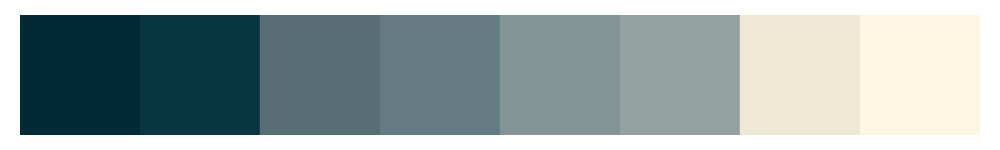

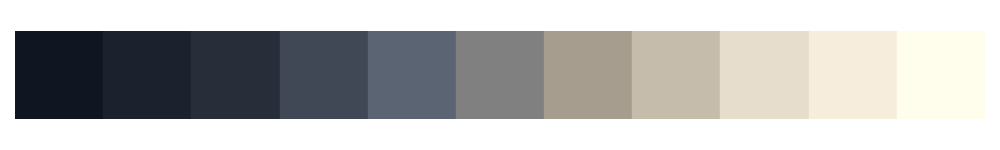

In [7]:
# Then, we define the base colours using symmetric lightness variations around the central lightness Lc
Lc = 0.6
H = 260*np.pi/180

dL_vals = np.array([0.1,0.2,0.3,0.35,0.4])
dL_vals = np.concatenate((-np.flip(dL_vals), [0], dL_vals))
L_vals = Lc+dL_vals

Cm = 0.3*get_max_chroma(L_vals[0], H)
C_vals = Cm*np.ones(5)
C_vals = np.concatenate((np.flip(C_vals), [0], -C_vals))

solarized_oklab.add_group("base", oklab=np.stack((Lc+dL_vals, C_vals*np.cos(H), C_vals*np.sin(H)),axis=-1))

plot_compact_colour_swatch(solarized.rgb["base"], "Solarized base colours")
plot_compact_colour_swatch(solarized_oklab.rgb["base"], "Solarized-OKLab base colours");

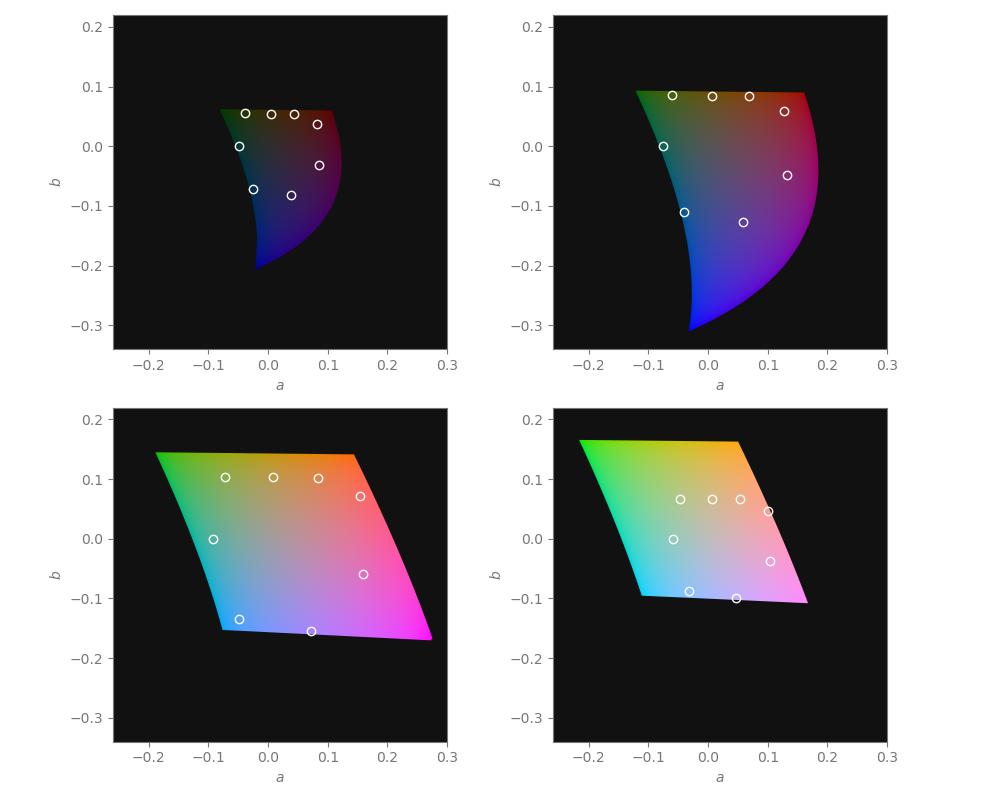

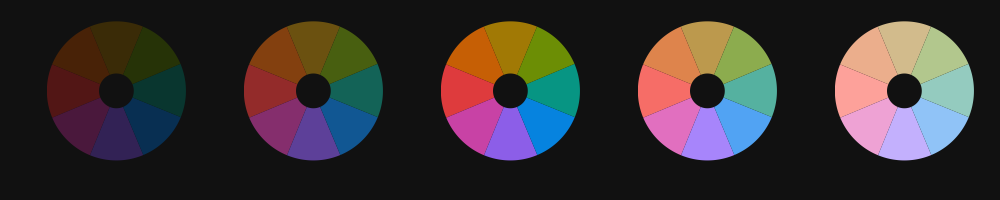

In [17]:
# Finally, we define the light/dark alternative accent colours
L_vals = [Lc-0.3, Lc-0.15, Lc, Lc+0.1, Lc+0.2]
scale_vals = [0.45, 0.7, 1, 0.85, 0.55]
group_names = ["accent900","accent700","accent500","accent300","accent100"]
for i,group_name in enumerate(group_names):
    oklab_cols = solarized_oklab.oklab["accent"].copy()
    oklab_cols[:,0] = L_vals[i]
    oklab_cols[:,1:] *= scale_vals[i]
    solarized_oklab.add_group(group_name, oklab=oklab_cols)

with plt.rc_context(rc_params):
    fig_title = "sRGB Gamut in Oklab + Solarized-OKLab alternative accent colours"
    plt.close(fig_title)
    fig,axes = plt.subplots(2, 2, figsize=(10,8), num=fig_title)
    for iplot,i in enumerate([0,1,3,4]):
        ax = axes[iplot//2, iplot%2]
        plot_gamut_in_oklab(L_vals[i], "sRGB Gamut in Oklab + New tints", figure=fig, axes=ax)
        ax.plot(*solarized_oklab.oklab[group_names[i]][:,1:].T, 'wo', mfc='none')

fig,axes = plot_multi_circular_swatch(*(solarized_oklab.rgb[g] for g in group_names), fignum="Solarized-OKLab alternative accent colours")

In [19]:
palette_lua = []
palette_lua.append("---@class Palette\nlocal M = {\n")
for ic,col_name in enumerate(["yellow","orange","red","magenta","violet","blue","cyan","green"]):
    for group_name in ["accent","accent100","accent300","accent500","accent700","accent900"]:
        palette_lua.append(f"\t{col_name+group_name[6:]} = \"{solarized_oklab.hex[group_name][ic]}\",\n")
for ic,col_name in enumerate(["base04","base03","base02","base01","base00","fg","base0","base1","base2","base3","base4"]):
    palette_lua.append(f"\t{col_name} = \"{solarized_oklab.hex["base"][ic]}\",\n")
palette_lua.append(f"\tbg = \"{solarized_oklab.hex["base"][0]}\",\n")
palette_lua.append(f"\tbg_highlight = \"{solarized_oklab.hex["base"][1]}\",\n")
palette_lua.append("\tnone = \"NONE\"\n")
palette_lua.append("}\nreturn M")
with open("lua\\solarized-oklab\\default_palette.lua", "w") as f:
    f.writelines(palette_lua)